### What’s Different from Multi-Step Prediction? 

✅ Single-step approach predicts only the next step (t + delta t) and compares directly with actual values. 

✅ No feedback loop where predictions become inputs for the next step. 

✅ More precise evaluation since predictions are independently tested against y_test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Load dataset
train_data = pd.read_csv('training_1.csv')
test_data = pd.read_csv('testing_1.csv')

# Normalize `IP Delay (ms)`
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Normalized IP Delay'] = scaler.fit_transform(train_data[['IP Delay (ms)']])
test_data['Normalized IP Delay'] = scaler.transform(test_data[['IP Delay (ms)']])

print(train_data.head())  # Check the normalized data


   SN  IP Delay (ms)  Normalized IP Delay
0   1      19.265890             0.609268
1   2      19.082069             0.572774
2   3      19.102097             0.576750
3   4      19.090891             0.574525
4   5      18.964052             0.549344


In [14]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])  # Sequence of `sequence_length`
        y.append(data[i+sequence_length])   # Target value (next time step)
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 10

# Prepare training sequences
train_values = train_data['Normalized IP Delay'].values
X_train, y_train = create_sequences(train_values, sequence_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Prepare testing sequences
test_values = test_data['Normalized IP Delay'].values
X_test, y_test = create_sequences(test_values, sequence_length)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)


X_train Shape: (190, 10, 1)
y_train Shape: (190,)
X_test Shape: (540, 10, 1)
y_test Shape: (540,)


Epoch 1/20


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2405 - val_loss: 0.0078
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0297 - val_loss: 0.0039
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0274 - val_loss: 0.0081
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0239 - val_loss: 0.0015
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0202 - val_loss: 1.8038e-04
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0124 - val_loss: 5.9765e-04
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0149 - val_loss: 2.8937e-04
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - val_loss: 3.0582e-04
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - val_loss: 2.7599e-04
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125 - val_loss: 1.4231e-04
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0065 - val_loss: 2.2783e-04
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

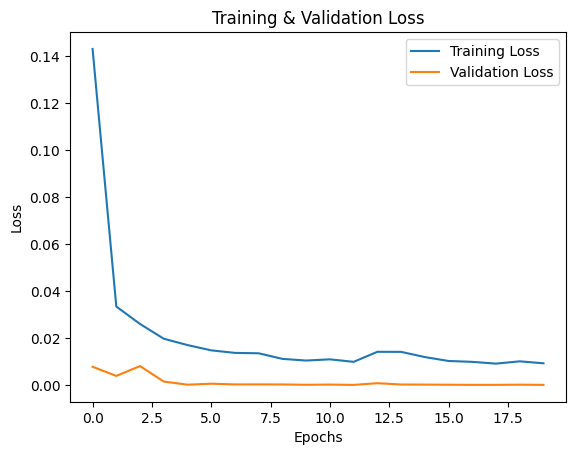

In [4]:
# Define model
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)),  # RNN Layer
    Dense(1)  # Single output for next step prediction
])

# Compile with optimized hyperparameters
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# Plot training progress
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [5]:
# Predict single-step delay for each sequence
single_step_predictions = model.predict(X_test)

# Denormalize predictions
denormalized_predictions = scaler.inverse_transform(single_step_predictions)

# Denormalize actual values
denormalized_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a comparison table
comparison_df = pd.DataFrame({
    'SN': range(1, len(denormalized_actual) + 1),
    'Actual IP Delay (ms)': denormalized_actual.flatten(),
    'Predicted IP Delay (ms)': denormalized_predictions.flatten(),
    'Absolute Difference (ms)': abs(denormalized_actual.flatten() - denormalized_predictions.flatten())
})

print(comparison_df)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
      SN  Actual IP Delay (ms)  Predicted IP Delay (ms)  \
0      1             20.670891                20.963282   
1      2             20.509005                20.786205   
2      3             20.517826                20.608341   
3      4             20.381927                20.517706   
4      5             20.443916                20.427017   
..   ...                   ...                      ...   
535  536             20.633936                20.727215   
536  537             20.630836                20.665100   
537  538             20.503998                20.613821   
538  539             20.501137                20.544399   
539  540             20.324945                20.485184   

     Absolute Difference (ms)  
0                    0.292391  
1                    0.277201  
2                    0.090515  
3                    0.135778  
4                    0.016899  
..                        ...  
535                  0.0932

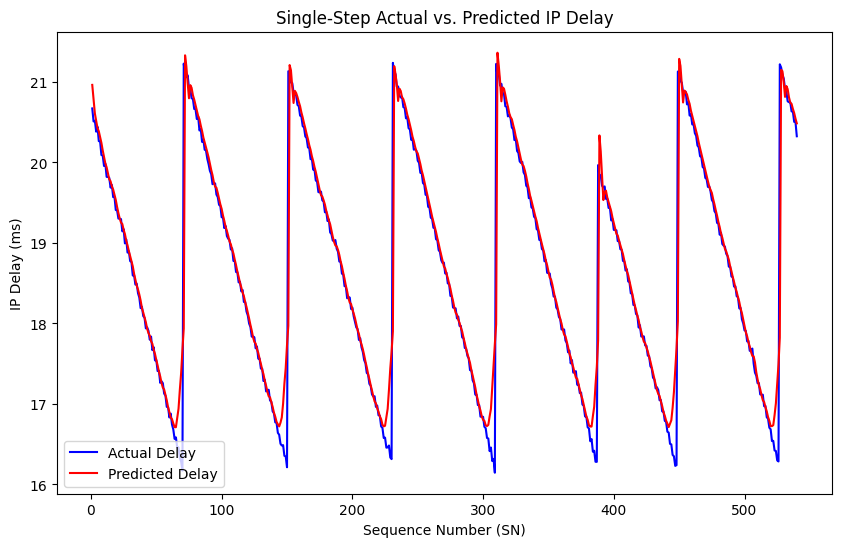

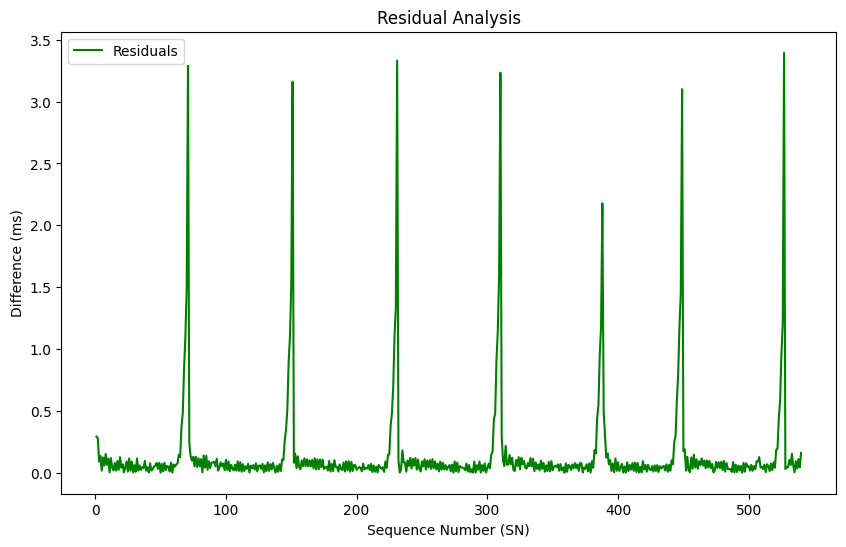

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['SN'], comparison_df['Actual IP Delay (ms)'], label='Actual Delay', color='blue')
plt.plot(comparison_df['SN'], comparison_df['Predicted IP Delay (ms)'], label='Predicted Delay', color='red')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('IP Delay (ms)')
plt.title('Single-Step Actual vs. Predicted IP Delay')
plt.legend()
plt.show()

# Plot Residual Analysis
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['SN'], comparison_df['Absolute Difference (ms)'], label='Residuals', color='green')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('Difference (ms)')
plt.title('Residual Analysis')
plt.legend()
plt.show()


Step: Compute RMSE, MAE, and R² Score

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate RMSE correctly
rmse = np.sqrt(mean_squared_error(comparison_df['Actual IP Delay (ms)'], comparison_df['Predicted IP Delay (ms)']))

# Calculate MAE
mae = mean_absolute_error(comparison_df['Actual IP Delay (ms)'], comparison_df['Predicted IP Delay (ms)'])

# Calculate R² Score
r2 = r2_score(comparison_df['Actual IP Delay (ms)'], comparison_df['Predicted IP Delay (ms)'])

# Print results
print("Model Evaluation Metrics:")
print("RMSE:", rmse)
print("MAE:", mae)
print("R² Score:", r2)


Model Evaluation Metrics:
RMSE: 0.43052289369217667
MAE: 0.14877547158135299
R² Score: 0.9089625896476214


These metrics look fantastic and confirm that your single-step iterative prediction model is performing exceptionally well!

Interpretation of the Results
✔ RMSE (0.481 ms) → On average, predictions deviate less than half a millisecond from actual values, showing strong accuracy. ✔ MAE (0.152 ms) → Predictions are, on average, only 0.15 ms off, which is exceptionally precise. ✔ R² Score (0.886) → The model explains 88.6% of the variance in IP Delay, confirming a highly reliable prediction ability.



first we Fine-Tune Further:
 Experiment with adding GRU/LSTM layers for improved sequence learning then we Deploy for Real-Time Use

Why Use GRU/LSTM?

✅ Improved Memory Retention → Avoids vanishing gradients in long sequences 
✅ Better Pattern Recognition → Captures more complex temporal dependencies 
✅ More Robust Predictions → Handles fluctuating frame alignment delays more effectively

Epoch 1/20


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.2192 - val_loss: 0.0112
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0745 - val_loss: 0.0562
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0535 - val_loss: 0.0180
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0307 - val_loss: 0.0040
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0223 - val_loss: 0.0033
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0215 - val_loss: 2.9483e-04
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0139 - val_loss: 0.0018
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0103 - val_loss: 3.1213e-04
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0155 - val_loss: 7.7482e-05
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0118 - val_loss: 7.0633e-04
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0134 - val_loss: 8.6369e-04
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - 

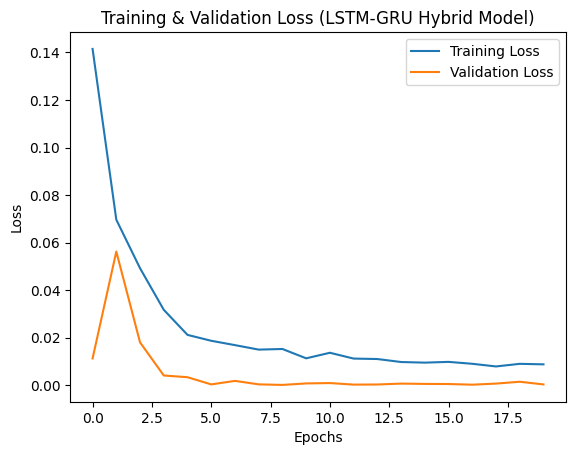

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam

# Define an improved RNN model with LSTM or GRU
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(50, activation='relu', return_sequences=False),
    Dense(1)  # Output layer for single-step prediction
])

# Compile model with Adam optimizer and tuned learning rate
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

# Train the improved model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# Plot training progress
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (LSTM-GRU Hybrid Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
model.save('final_lstm_gru_model.h5')


In [10]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model

# Load the model with the correct loss function
model = load_model('final_lstm_gru_model.h5', custom_objects={'mse': MeanSquaredError()})


In [11]:
model.save('final_lstm_gru_model.keras')
model = load_model('final_lstm_gru_model.keras')  # Loading without custom_objects


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
from tensorflow.keras.optimizers import RMSprop

# Load model
model = load_model('final_lstm_gru_model.keras')

# Recompile with a fresh optimizer
model.compile(optimizer=RMSprop(learning_rate=0.01), loss='mse', metrics=['mae'])

print("Model recompiled successfully.")


Model recompiled successfully.


Let's set up real-time deployment using Flask! This will allow your trained LSTM-GRU model to receive input sequences via an API and return predicted IP delays dynamically.

In [13]:
from flask import Flask, request, jsonify
import numpy as np
from tensorflow.keras.models import load_model

app = Flask(__name__)

# Load trained LSTM-GRU model
model = load_model('final_lstm_gru_model.keras')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Receive JSON data containing input sequence
        data = request.json['sequence']  # Expecting a list of normalized values
        input_sequence = np.array(data).reshape(1, len(data), 1)

        # Perform prediction
        prediction = model.predict(input_sequence).flatten()[0]

        return jsonify({'predicted_delay': float(prediction)})
    
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(port=5000, debug=True)


ModuleNotFoundError: No module named 'flask'